# ResNet Model Implementation - CIFAR-10
---

In [ ]:
%matplotlib inline
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch import nn
from collections import defaultdict
from matplotlib import pyplot as plt

import torch
import numpy as np

# Dataset and DataLoader

In [ ]:
cifar_dataset = datasets.CIFAR10(
    root='../dataset/CIFAR-10',
    train=True,
    download=True,
    transform=transforms.ToTensor(),
)

imgs = [img for img, _ in cifar_dataset]
imgs = torch.stack(imgs, dim=0).numpy()

cifar10_means = [
    imgs[:, 0, :, :].mean(),
    imgs[:, 1, :, :].mean(),
    imgs[:, 2, :, :].mean(),
]
cifar10_stds = [
    imgs[:, 0, :, :].std(),
    imgs[:, 1, :, :].std(),
    imgs[:, 2, :, :].std(),
]

print('image_shape:', imgs.shape)
print('image_mean:', cifar10_means)
print('image_std:', cifar10_stds)

In [ ]:
from torchvision.transforms.transforms import ColorJitter

img_transforms = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    # transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=cifar10_means, std=cifar10_stds),
])

train_dataset = datasets.CIFAR10(
    root='../dataset/CIFAR-10',
    train=True,
    download=True,
    transform=img_transforms,
)

test_dataset = datasets.CIFAR10(
    root='../dataset/CIFAR-10',
    train=False,
    download=True,
    transform=img_transforms
)

In [ ]:
batch_size = 512

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

# Model
---
## Residual Block
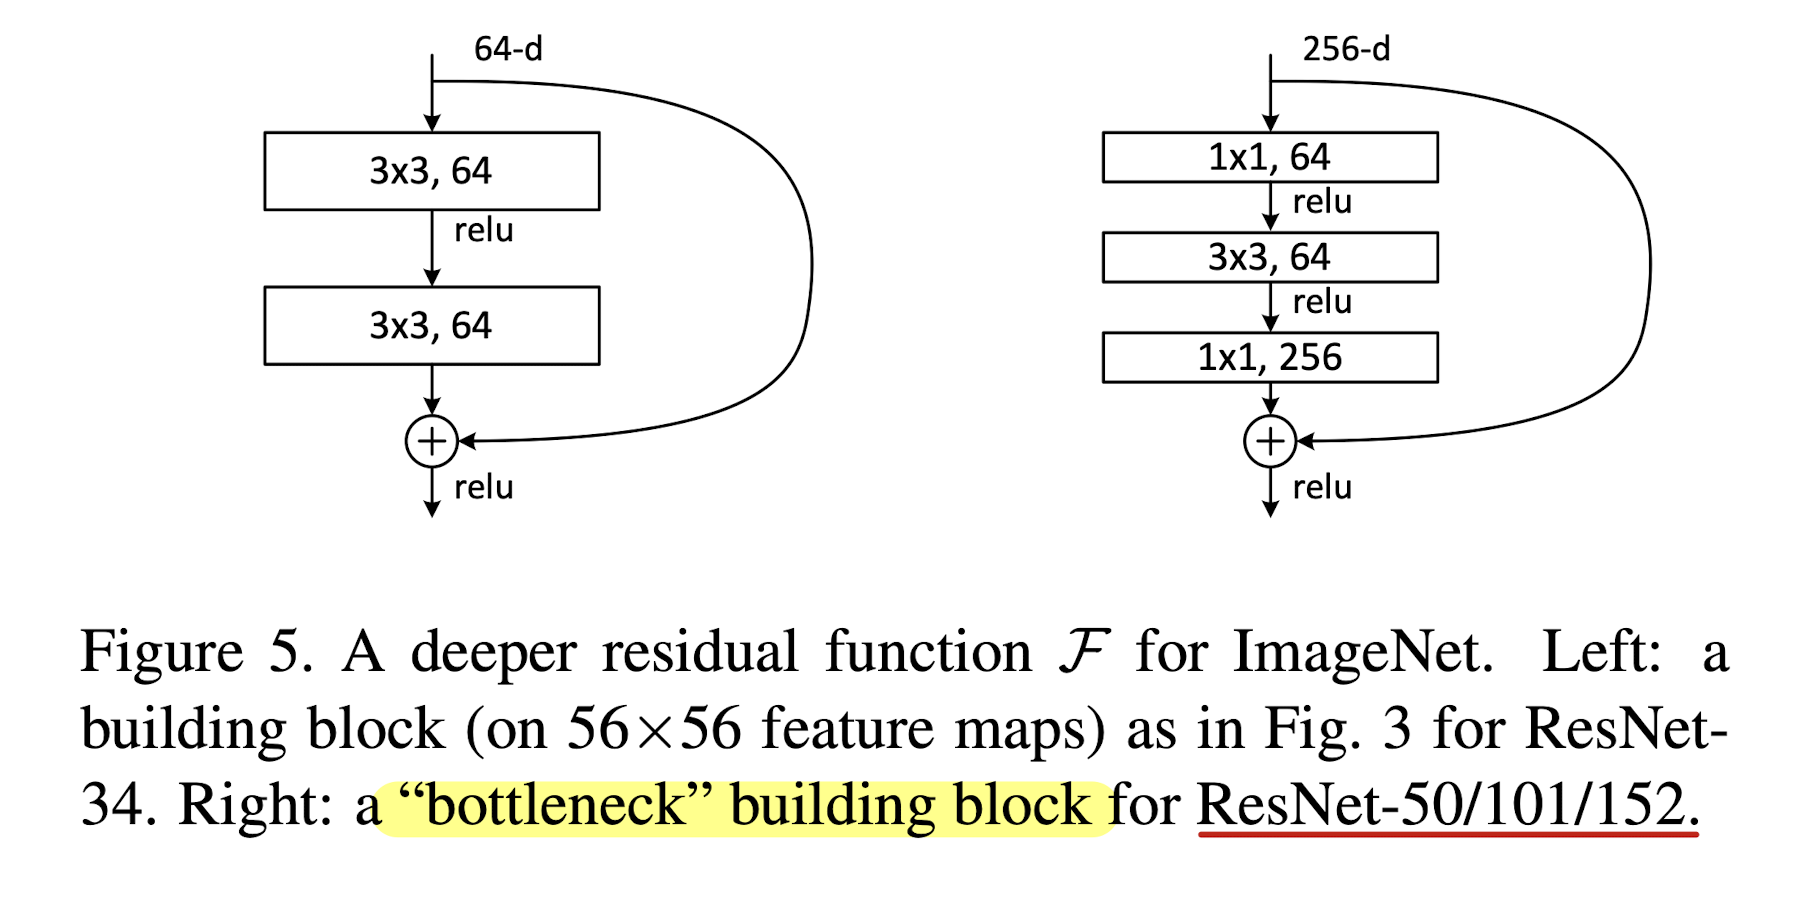

In [ ]:
class ResidualBlock(nn.Module):
    def __init__(
        self, 
        in_channels,
        out_channels,
        downsample=False,
        dim_exp=False,
    ):
        super(ResidualBlock, self).__init__()
        
        self.downsample_stride = 2 if downsample else 1
        self.downsample = downsample
        self.dim_exp = dim_exp
        
        # Conv 3 x 3
        self.conv1 = nn.Conv2d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=3,
            stride=self.downsample_stride,
            padding=1,
            bias=False,
        )
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu1 = nn.ReLU(inplace=True)
        
        # Conv 3 x 3
        self.conv2 = nn.Conv2d(
            in_channels=out_channels,
            out_channels=out_channels,
            kernel_size=3,
            stride=1,
            padding=1,
            bias=False,
        )
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        # Shortcut Connection
        if self.downsample:
            self.proj = nn.Sequential(
                nn.Conv2d(
                    in_channels=in_channels,
                    out_channels=out_channels,
                    kernel_size=1,
                    stride=self.downsample_stride,
                    bias=False
                ),
                nn.BatchNorm2d(out_channels),
            )
        if self.dim_exp:
            self.proj = nn.Sequential(
                nn.Conv2d(
                    in_channels=in_channels,
                    out_channels=out_channels,
                    kernel_size=1,
                    stride=1,
                    bias=False,
                ),
                nn.BatchNorm2d(out_channels),
            )
            
        # Final ReLU
        self.relu2 = nn.ReLU(inplace=True)
        
    def forward(self, x):
        identity = x
        if self.downsample or self.dim_exp:
            identity = self.proj(identity)
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        
        x += identity
        out = self.relu2(x)
        
        return out

## Bottleneck
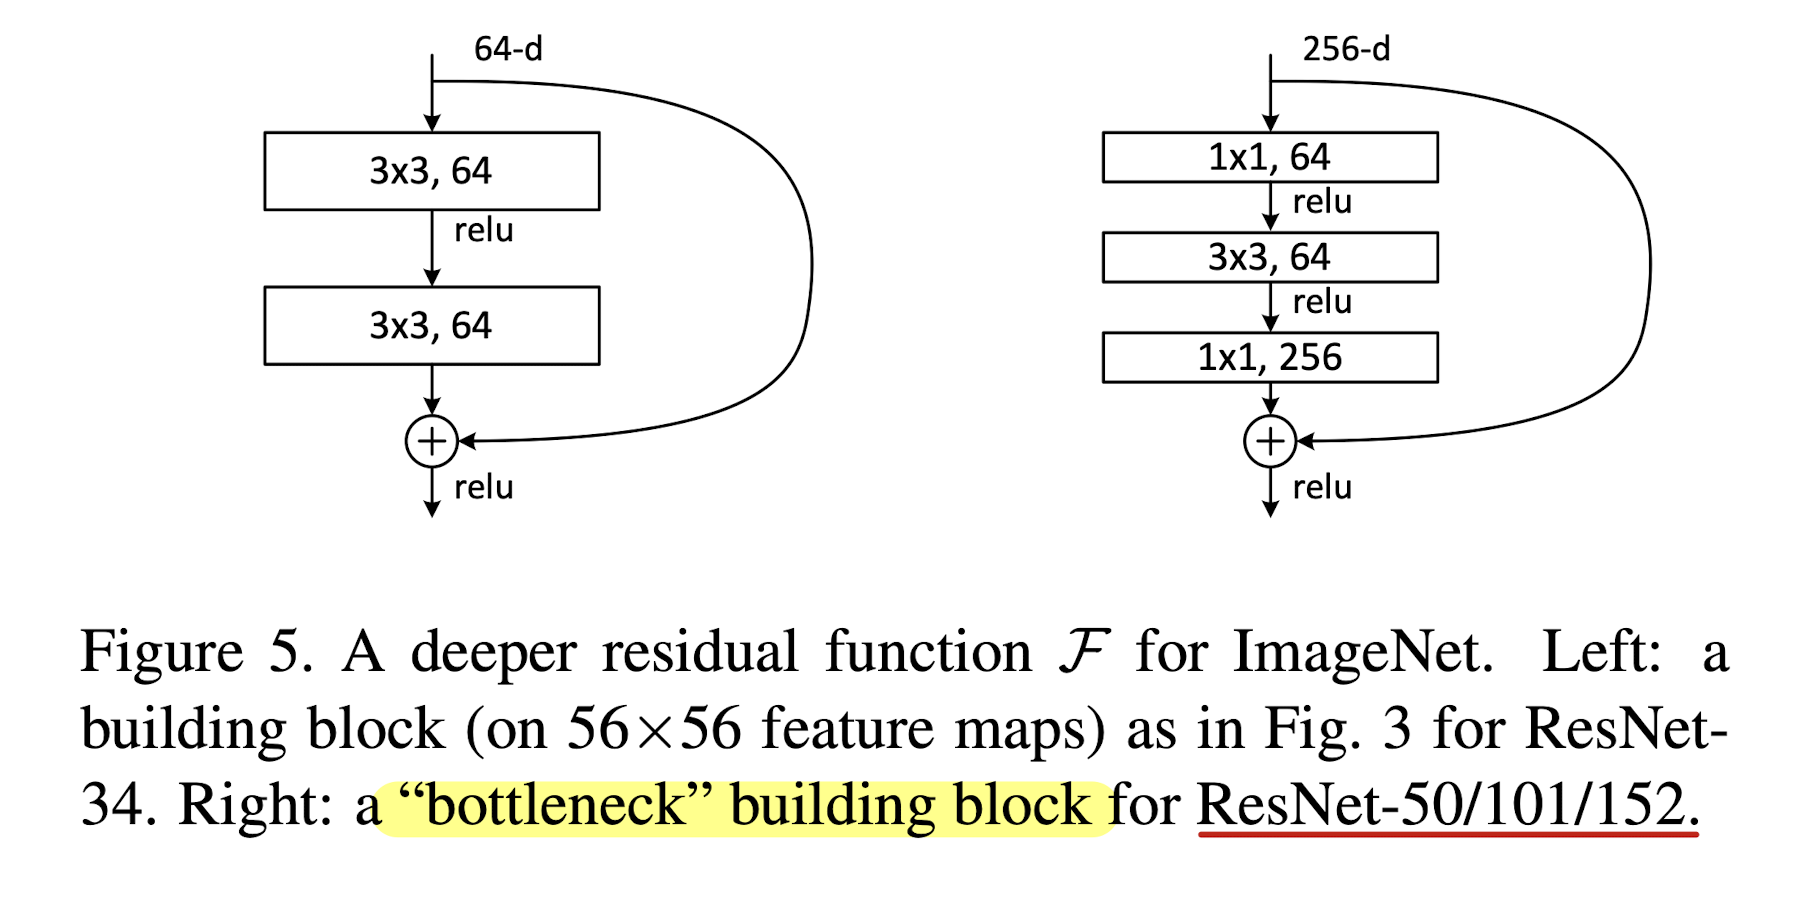

In [ ]:
class Bottleneck(nn.Module):
    def __init__(
        self,
        in_channels,
        mid_channels,
        out_channels,
        downsample=False,
        dim_exp=False,
    ):
        super(Bottleneck, self).__init__()
        
        self.downsample = downsample
        self.dim_exp = dim_exp
        self.downsample_stride = 2 if self.downsample else 1
        
        # Conv 1 x 1
        self.conv1 = nn.Conv2d(
            in_channels=in_channels,
            out_channels=mid_channels,
            kernel_size=1,
            stride=self.downsample_stride,
            bias=False,
        )
        self.bn1 = nn.BatchNorm2d(mid_channels)
        self.relu1 = nn.ReLU(inplace=True)
        
        # Conv 3 x 3
        self.conv2 = nn.Conv2d(
            in_channels=mid_channels,
            out_channels=mid_channels,
            kernel_size=3,
            stride=1,
            padding=1,
            bias=False,
        )
        self.bn2 = nn.BatchNorm2d(mid_channels)
        self.relu2 = nn.ReLU(inplace=True)
        
        # Conv 1 x 1
        self.conv3 = nn.Conv2d(
            in_channels=mid_channels,
            out_channels=out_channels,
            kernel_size=1,
            bias=False,
        )
        self.bn3 = nn.BatchNorm2d(out_channels)
        self.relu3 = nn.ReLU(inplace=True)
        
        # Shortcut Connection
        if downsample:
            self.proj = nn.Sequential(
                nn.Conv2d(
                    in_channels=in_channels,
                    out_channels=out_channels,
                    kernel_size=1,
                    stride=self.downsample_stride,
                    bias=False,
                ),
                nn.BatchNorm2d(out_channels)
            )
        elif dim_exp:
            self.proj = nn.Sequential(
                nn.Conv2d(
                    in_channels=in_channels,
                    out_channels=out_channels,
                    kernel_size=1,
                    stride=1,
                    bias=False,
                ),
                nn.BatchNorm2d(out_channels),
            )
        
        # Final ReLU
        self.relu4 = nn.ReLU(inplace=True)
    
    def forward(self, x):
        identity = x
        if self.downsample or self.dim_exp:
            identity = self.proj(x)
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu3(x)
        
        # inplace Error -> Solution : using clone
        # Reference : https://github.com/NVlabs/FUNIT/issues/23
        x = x.clone() + identity
        out = self.relu4(x)
        
        return out

## ResNet
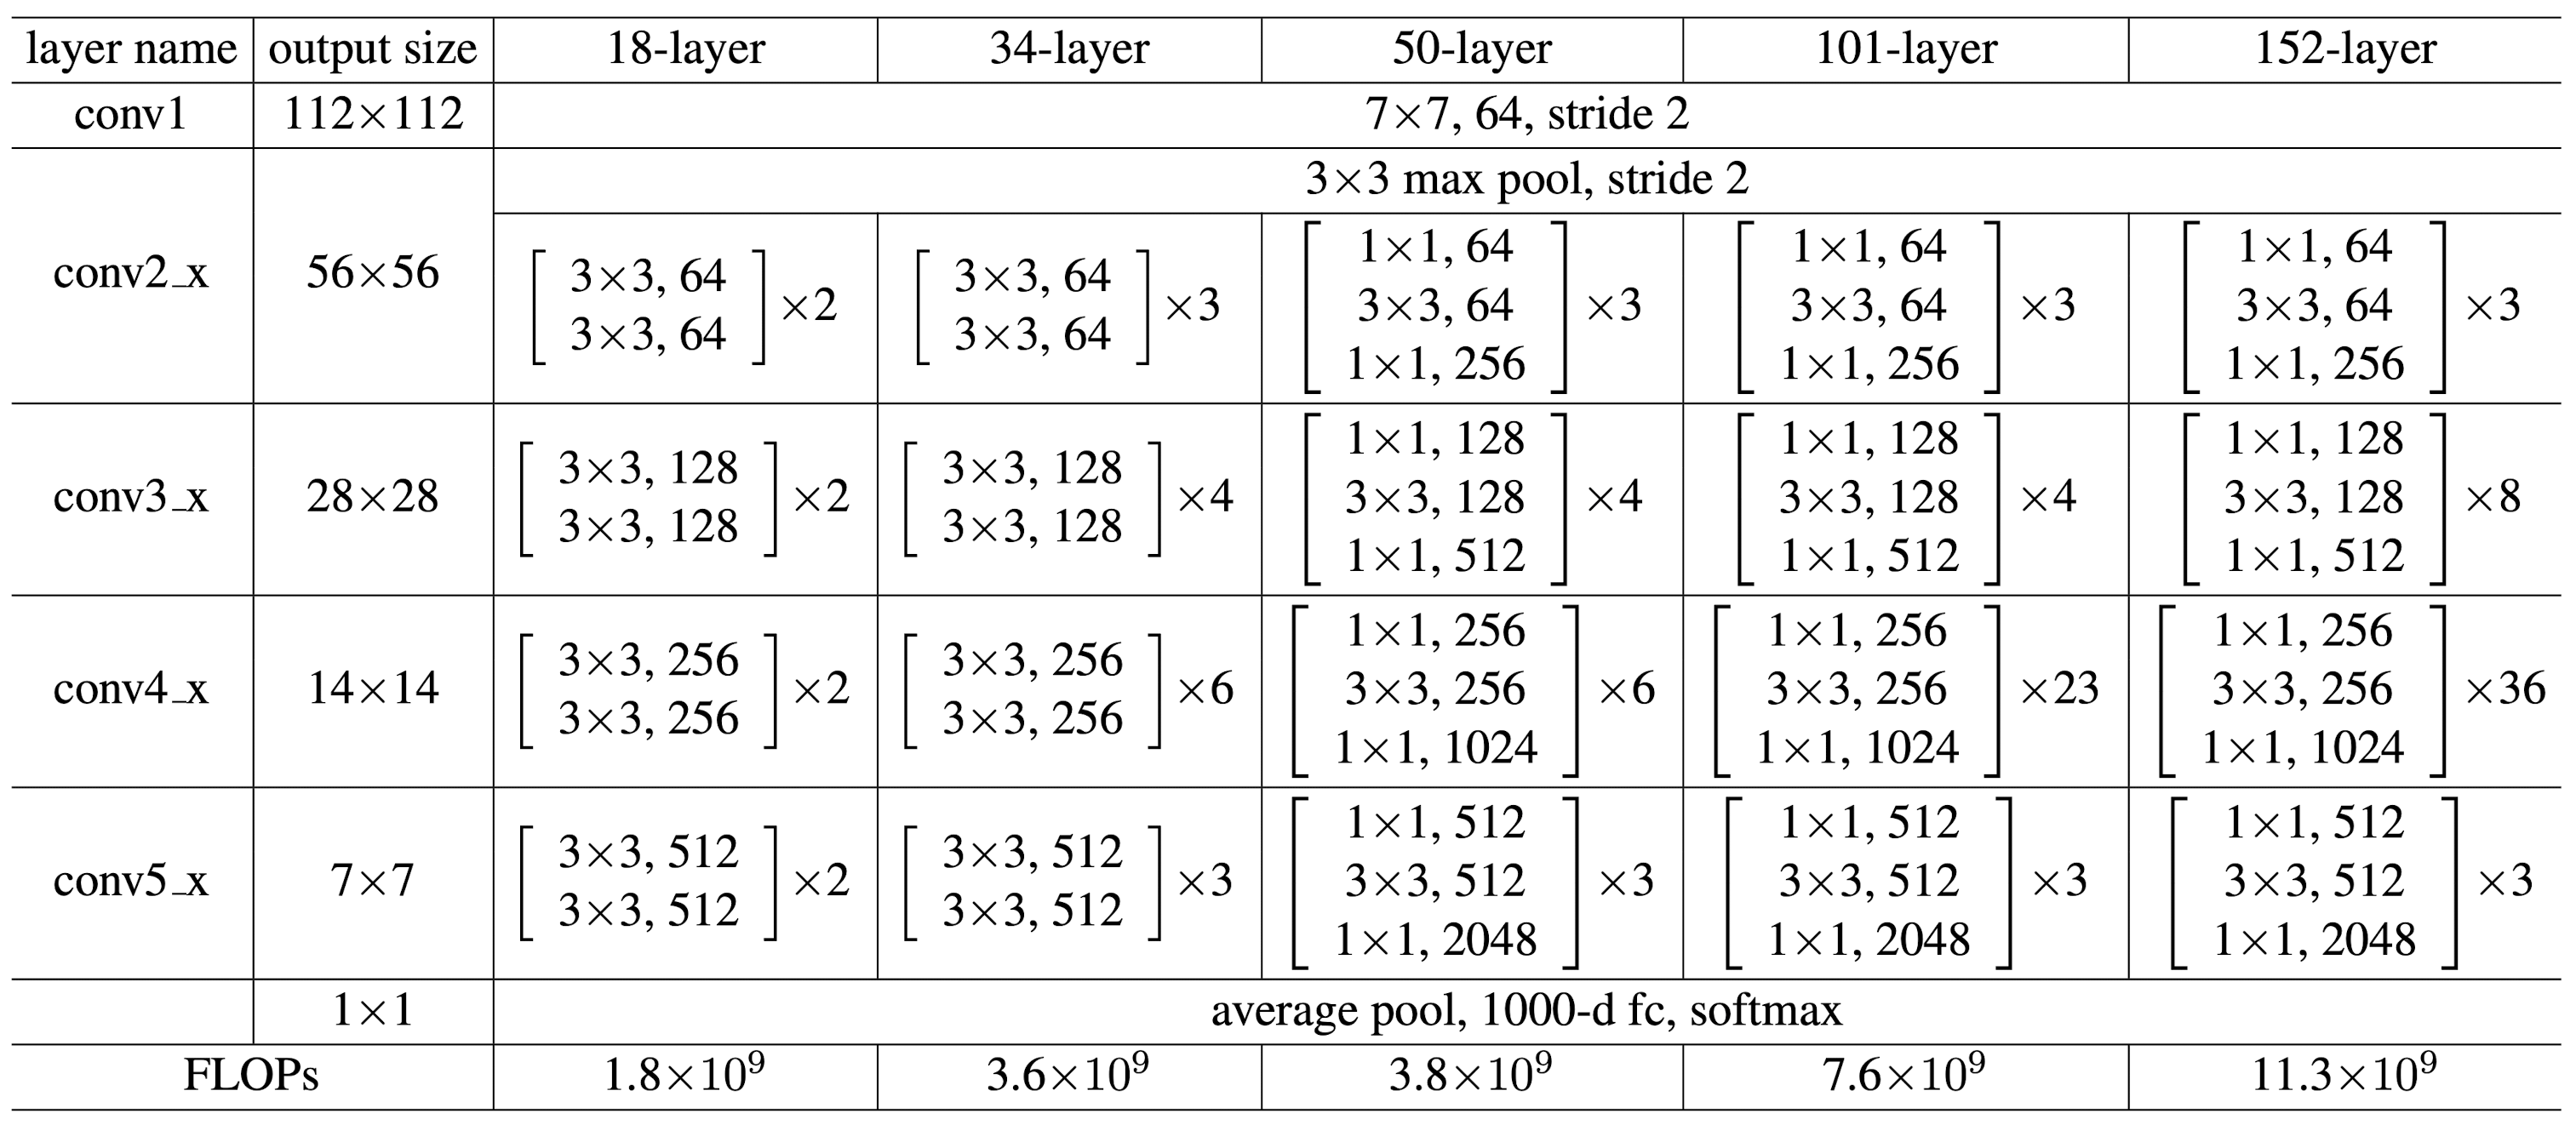

In [ ]:
class ResNet(nn.Module):
    def __init__(self, num_layers=18, num_cls=10):
        super(ResNet, self).__init__()
        self.num_cls = num_cls
        self.conv1 = nn.Conv2d(
            in_channels=3,
            out_channels=64,
            kernel_size=7,
            stride=2,
            padding=3,
        )
        self.max_pool = nn.MaxPool2d(kernel_size=3, stride=2)
        if num_layers == 18:
            self.conv2 = self._make_layers(
                num_layers=num_layers,
                num_stacks=2,
                in_channels=64,
                out_channels=128,
                downsample=False,
                dim_exp=True,
            )
            self.conv3 = self._make_layers(
                num_layers=num_layers,
                num_stacks=2,
                in_channels=128,
                out_channels=256,
                downsample=True,
                dim_exp=True,
            )
            self.conv4 = self._make_layers(
                num_layers=num_layers,
                num_stacks=2,
                in_channels=256,
                out_channels=512,
                downsample=True,
                dim_exp=True,
            )
            self.conv5 = self._make_layers(
                num_layers=num_layers,
                num_stacks=2,
                in_channels=512,
                out_channels=1024,
                downsample=True,
                dim_exp=True,
            )
            self.fc_in_dim = 1024
        else:    # num_layers == 50
            self.conv2 = self._make_layers(
                num_layers=num_layers,
                num_stacks=3,
                in_channels=64,
                mid_channels=64,
                downsample=False,
            )
            self.conv3 = self._make_layers(
                num_layers=num_layers,
                num_stacks=4,
                in_channels=64*4,
                mid_channels=128,
                downsample=True,
            )
            self.conv4 = self._make_layers(
                num_layers=num_layers,
                num_stacks=6,
                in_channels=128*4,
                mid_channels=256,
                downsample=True,
            )
            self.conv5 = self._make_layers(
                num_layers=num_layers,
                num_stacks=3,
                in_channels=256*4,
                mid_channels=512,
                downsample=True,
            )
            self.fc_in_dim = 512 * 4
        
        self.avg_pool = nn.AvgPool2d(kernel_size=1, stride=1)
        # self.avg_pool = nn.AdaptiveAvgPool2d(output_size=(1, 1))
        self.flatten = nn.Flatten()
        self.fc_layer = nn.Linear(self.fc_in_dim, self.num_cls)
        
        # Weight Initialization
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)
    def _make_layers(
        self,
        num_layers,
        num_stacks,
        in_channels=0,
        mid_channels=0,
        out_channels=0,
        downsample=False,
        dim_exp=False,
    ):
        layers = []
        if num_layers == 18:
            layers.append(
                ResidualBlock(
                    in_channels=in_channels,
                    out_channels=in_channels,
                    downsample=downsample,
                ),
            )
            layers.append(
                ResidualBlock(
                    in_channels=in_channels,
                    out_channels=out_channels,
                    dim_exp=dim_exp,
                ),
            )
        else:    # num_layers == 50
            layers.append(
                Bottleneck(
                    in_channels=in_channels,
                    mid_channels=mid_channels,
                    out_channels=mid_channels * 4,
                    downsample=downsample,
                    dim_exp=True,
                )
            )
            for i in range(1, num_stacks):
                if i == (num_stacks-1):
                    print('last')
                    dim_exp=True
                    
                layers.append(
                    Bottleneck(
                        in_channels=mid_channels * 4,
                        mid_channels=mid_channels,
                        out_channels=mid_channels * 4,
                        downsample=False,
                        dim_exp=dim_exp,
                    )
                )
        return nn.Sequential(*layers)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.max_pool(x)
        
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.avg_pool(x)
        
        x = self.flatten(x)
        out = self.fc_layer(x)
        
        return out

## ResNet-18

In [ ]:
num_layers = 18
# num_layers = 50
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = ResNet(num_layers=num_layers).to(device)
print(model)

## ResNet-50

In [ ]:
num_layers = 50
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = ResNet(num_layers=num_layers).to(device)
print(model)

# Training and Test
---
## Loss Function, Optimizer, and Scheduler

In [ ]:
epochs = 100
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(
    model.parameters(),
    lr=1e-1,
    momentum=0.9,
    weight_decay=1e-4,
)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max=epochs,    # epochs
)

## Training Function

In [ ]:
def train(dataloader, model, loss_fn, optimizer, scheduler, device):
    total_nums = len(dataloader.dataset)
    model.train()
    
    losses = []
    for batch, (images, labels) in enumerate(dataloader):
        images, labels = images.to(device), labels.to(device)
        
        preds = model(images)
        loss = loss_fn(preds, labels)
        losses.append(loss.item() * len(images))
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if batch & 100 == 0:
            loss, cur_nums = loss.item(), batch * len(images)
            print(f'loss: {loss:>7f} [{cur_nums:>5d}/{total_nums:>5d}]')
    
    scheduler.step()
    return sum(losses) / total_nums

## Test Function

In [ ]:
def test(dataloader, model, loss_fn, device):
    total_nums = len(dataloader.dataset)
    model.eval()
    
    loss, corrects = 0, 0
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            preds = model(images)
            loss += loss_fn(preds, labels).item() * len(images)
            corrects += (preds.argmax(1) == labels).type(torch.float).sum().item()
        
        loss /= total_nums
        acc = corrects / total_nums * 100
        print(f'Test Results:\n Accuracy: {acc:>0.1f}%, Avg Loss: {loss:>8f}\n')
    
    return loss, acc

## Training and Test (ResNet-18)

In [ ]:
results = defaultdict(list)
for epoch in range(epochs):
    print(f'Epoch {epoch+1}:')
    print('-' * 30)
    
    train_loss = train(train_dataloader, model, loss_fn, optimizer, scheduler, device)
    test_loss, test_acc = test(test_dataloader, model, loss_fn, device)
    
    results['train_loss'].append(train_loss)
    results['test_loss'].append(test_loss)
    results['test_acc'].append(test_acc)
    
print('Done.')

## Training and Test (ResNet-50)

In [ ]:
results = defaultdict(list)
for epoch in range(epochs):
    print(f'Epoch {epoch+1}:')
    print('-' * 30)
    
    train_loss = train(train_dataloader, model, loss_fn, optimizer, scheduler, device)
    test_loss, test_acc = test(test_dataloader, model, loss_fn, device)
    
    results['train_loss'].append(train_loss)
    results['test_loss'].append(test_loss)
    results['test_acc'].append(test_acc)
    
print('Done.')

# Visualization
---
## ResNet-18

In [ ]:
figure, axis = plt.subplots(1, 2, figsize=(10, 5))
epoch_nums = range(1, epochs+1)

axis[0].plot(epoch_nums, results['train_loss'])
axis[0].plot(epoch_nums, results['test_loss'])
axis[0].set_xlabel('Epoch')
axis[0].set_ylabel('Loss')
axis[0].set_title('Loss')
axis[0].legend(['train', 'test'])

axis[1].plot(epoch_nums, results['test_acc'])
axis[1].set_xlabel('Epoch')
axis[1].set_ylabel('Accuracy')
axis[1].set_title('Accuracy')
axis[1].legend(['test'])

plt.tight_layout()
plt.show()

## ResNet-50

In [ ]:
figure, axis = plt.subplots(1, 2, figsize=(10, 5))
epoch_nums = range(1, epochs+1)

axis[0].plot(epoch_nums, results['train_loss'])
axis[0].plot(epoch_nums, results['test_loss'])
axis[0].set_xlabel('Epoch')
axis[0].set_ylabel('Loss')
axis[0].set_title('Loss')
axis[0].legend(['train', 'test'])

axis[1].plot(epoch_nums, results['test_acc'])
axis[1].set_xlabel('Epoch')
axis[1].set_ylabel('Accuracy')
axis[1].set_title('Accuracy')
axis[1].legend(['test'])

plt.tight_layout()
plt.show()

# Reference
---
- https://github.com/pytorch/vision/blob/7be2f55b1ac848faa5aea4fd19bca7e150c20907/torchvision/models/resnet.py#L52
- https://medium.com/analytics-vidhya/embedding-your-image-in-google-colab-markdown-3998d5ac2684